# DWPP Test Result Analysis

# Import

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12


# Make Reference Path

In [146]:
def make_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    paths = []
    # 生成するカーブの角度パターン
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_segment = 3.0  # 直線区間の長さパラメータ

    for theta in theta_list:
        # 1. 直進 (0 -> 1m)
        x1 = np.linspace(0, 1, 100)
        y1 = np.zeros_like(x1)
        
        # 2. 斜め直線 (角度thetaで長さl)
        # Note: 実際には直線補間だが、ここでは簡易的に生成
        x2 = np.linspace(1.0, 1.0 + l_segment * math.cos(theta), 300)
        y2 = np.linspace(0.0, l_segment * math.sin(theta), 300)
        
        # 3. 終端直進 (さらに3m進む)
        x3 = np.linspace(
            1.0 + l_segment * math.cos(theta), 
            4.0 + l_segment * math.cos(theta), 300)
        y3 = np.ones_like(x3) * l_segment * math.sin(theta)

        # 結合
        xs = np.concatenate([x1, x2, x3])
        ys = np.concatenate([y1, y2, y3])
        
        path = np.c_[xs, ys]
        
        paths.append(path)
        

    # 展開して返す
    return (paths[0], paths[1], paths[2])

PathA, PathB, PathC = make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}


Velocity Violation ratio

In [147]:
def calc_violation_rate(violation_flags) -> float:
    violation_count = np.sum(violation_flags)
    total_count = len(violation_flags)
    violation_rate = violation_count / total_count
    return violation_rate

Cross Track Error RMSE

In [148]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


Divide df

In [149]:
def divide_df_to_segments(df: pd.DataFrame, t_threshold: float) -> list:
    """
    Divide the DataFrame into segments based on time gaps exceeding the threshold.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a 'timestamp' column.
        t_threshold (float): Time gap threshold to identify segments.
        
    Returns:
        list: List of DataFrame segments.
    """
    t = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
    
    # diffをとる
    t_diff = np.diff(t, prepend=t[0])
    print(t_diff)
    
    # diffが閾値以上のindexでcsvを分割する
    split_indices = np.where(t_diff >= t_threshold)[0]
    
    # split_indices から各区間を作成
    split_points = np.r_[0, split_indices, len(df)]
    segments = []
    for start, end in zip(split_points[:-1], split_points[1:]):
        segment = df.iloc[start:end].copy()
        if not segment.empty:
            segments.append(segment)
    
    print(f"Found {len(segments)} segments (threshold={t_threshold})")
    for i, segment in enumerate(segments):
        span = segment["sec"].iloc[-1] - segment["sec"].iloc[0]
        print(f" segment {i}: rows={len(segment)}, span={span:.3f}s")
    
    return segments



Plot velocity profile

In [150]:
def plot_velocity_profile(t, v_real, w_real, v_cmd, w_cmd, path_name, controller_name):
    # Create subplots for translational and rotational velocities (horizontal layout)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot translational velocity
    ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit line
    ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')

    # Plot rotational velocity
    ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
    ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit lines
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
    ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

    # Set labels and legends
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Linear Velocity [m/s]')
    # ax1.set_yticks([0, 0.10, 0.20])
    ax1.grid(True, alpha=0.3)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angular Velocity [rad/s]')
    # ax2.set_ylim(-0.7, 0.7)
    # ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax2.grid(True, alpha=0.3)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{path_name}_{controller_name}_velocity_profile.png', dpi=300, bbox_inches='tight')
    plt.show()
    

Plot dynamic window

In [151]:
def plot_dynamic_window(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs, path_name, controller_name):
    base_dir = '/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow'
    os.makedirs(f'{base_dir}/{path_name}/{controller_name}', exist_ok=True)
    
    for idx, (curvature, v, w, next_v, next_w, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg) \
        in enumerate(zip(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs)):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        # Dynamic Windowの範囲を四角形でプロット
        vertexes = [
            (dw_min_v, dw_min_w),
            (dw_min_v, dw_max_w),
            (dw_max_v, dw_max_w),
            (dw_max_v, dw_min_w)
        ]
        rectangle = patches.Polygon(vertexes, closed=True, fill=False, color='black', alpha=1.0, label='Dynamic Window')
        ax.add_patch(rectangle)
        
        # omega = curvature * v の直線をプロット
        v_list = np.linspace(-0.1, 0.6, 100)
        omega_line = curvature * v_list
        ax.plot(v_list, omega_line, 'g--', label='ω = k * v')
        
        # 現在の速度点
        ax.scatter(v, w, s=12, color='blue', label='Current Velocity')
        # 速度指令値の速度点
        ax.scatter(next_v, next_w, s=12, color='red', label='Command Velocity')
        # 制御後の速度点
        ax.scatter(actual_v, actual_w, s=12, color='magenta', label='Actual Velocity')
        
        # v_regの描画
        ax.axvline(x=v_reg, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Regulated Velocity')
        
        ax.set_xlabel('Linear Velocity [m/s]')
        ax.set_ylabel('Angular Velocity [rad/s]')
        ax.set_xlim(-0.1, 0.6)
        ax.set_ylim(-1.2, 1.2)
        ax.grid(True, alpha=0.3)
        # ax.set_aspect('equal')
        # plt.legend()
        plt.savefig(f'{base_dir}/{path_name}/{controller_name}/{idx}.png', dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()
    

In [152]:
from os import times
import time


def data_analysis(segment, path_name, controller_name):
    # data aquisition
    timestamp = segment["sec"].to_numpy() + segment["nsec"].to_numpy() * 1e-9
    timestamp = timestamp - timestamp[0]
    curvature = segment["curvature"].to_numpy()
    v_now = segment["v_now"].to_numpy()
    w_now = segment["w_now"].to_numpy()
    v_cmd = segment["v_cmd"].to_numpy()
    w_cmd = segment["w_cmd"].to_numpy()
    actual_v = segment["v_nav"].to_numpy()
    actual_w = segment["w_nav"].to_numpy()
    v_real = segment["v_real"].to_numpy()
    w_real = segment["w_real"].to_numpy()
    dw_max_v = segment["dw_v_max"].to_numpy()
    dw_max_w = segment["dw_w_max"].to_numpy()
    dw_min_v = segment["dw_v_min"].to_numpy()
    dw_min_w = segment["dw_w_min"].to_numpy()
    v_reg = segment["v_reg"].to_numpy()
    
    # plot velocity profile
    plot_velocity_profile(timestamp, v_real, w_real, v_cmd, w_cmd, path_name, controller_name)
    
    # plot dynamic window
    plot_dynamic_window(curvature, v_now, w_now, v_cmd, w_cmd, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg, path_name, controller_name)

test

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PP_test.csv:
[0.         0.03274417 0.0331502  0.03346014 0.03299022 0.03334117
 0.03377056 0.03288531 0.03372335 0.0333271  0.03312254 0.03332901
 0.03333163 0.03318596 0.03333497 0.03332329 0.0335083  0.03325033
 0.03327751 0.03357363 0.03305578 0.03371572 0.03339243 0.03415251
 0.0324719  0.03292394 0.03345323 0.03315115 0.03338432 0.03367043
 0.03304601 0.03385377 0.03269768 0.0353477  0.03180766 0.03315425
 0.03363466 0.03315163 0.03311896 0.03318    0.03332019 0.03332305
 0.03336215 0.03338957 0.03330445 0.03332281 0.03371716 0.03304172
 0.03349137 0.03306842 0.03355336 0.03325057 0.03347445 0.03320408
 0.03310776 0.03371882 0.03300333 0.03398299 0.03263092 0.03364158
 0.03309178 0.03349829 0.03314853 0.03347349 0.0333128  0.03338194
 0.03333879 0.03310418 0.03355622 0.03336692 0.03326964 0.03321147
 0.03335357 0.03333592 0.03344393 0.03321266 0.03340602 0.033566
 0.03291559 0.03375125 0.033066

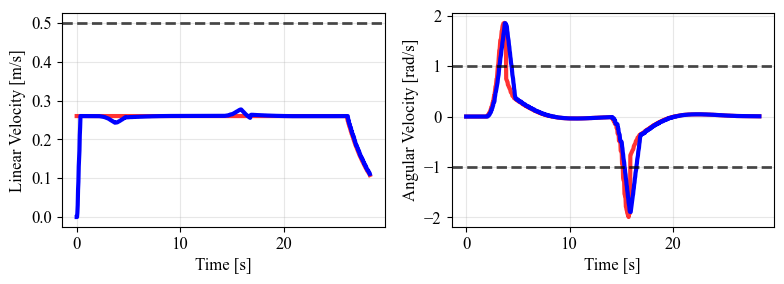

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb02bab6d50>>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [153]:
data_path = "/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PP_test.csv"
df = pd.read_csv(data_path)
print(f"Data from {data_path}:")

df = pd.read_csv(data_path)
t_threshold = 1.0  # seconds
segments = divide_df_to_segments(df, t_threshold)

# 各走行データ
idx = 0
segment = segments[idx]
data_analysis(df, "PathC", "DWPP")